# NNFL Assignment 2

# Ishan Dixit           -                           2018AAPS0333H

In [ ]:
#Importing libraries

import scipy.io
import numpy as np
import pandas as pd
import math
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import regularizers
from PIL import Image
import glob
import numpy as np
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline


In [ ]:
#Helper Functions

def holdout_crossvalid(data, train, val, test,norm=False):

    np.random.seed(0)
    if isinstance(data, pd.DataFrame):
        vec = data.to_numpy()
    else:
        vec=data
    np.random.shuffle(vec)
    total = data.shape[0]

    train_len = int(train * total)
    val_len = int(val * total)
    test_len = int(test * total)
    train = vec[:train_len, :vec.shape[1]-1]
    val = vec[train_len:train_len + val_len, :vec.shape[1]-1]
    test = vec[train_len + val_len:, :vec.shape[1]-1]

    train_label = vec[:train_len, vec.shape[1]-1].reshape(-1, 1)
    val_label = vec[train_len:train_len + val_len, vec.shape[1]-1].reshape(-1, 1)
    test_label = vec[train_len + val_len:, vec.shape[1]-1].reshape(-1, 1)
    
    if norm:
    
        x=[]
        mean=[]
        std=[]
        for i in range(train.shape[1]):
            x.append((train[:,i]-np.mean(train[:,i]))/np.std(train[:,i]))
            mean.append(np.mean(train[:,i]))
            std.append(np.std(train[:,i]))


        train=np.array(x).T


        x=[]
        for i in range(test.shape[1]):
            x.append((test[:,i]-mean[i])/std[i])

        test=np.array(x).T
        
        x=[]
        for i in range(val.shape[1]):
            x.append((val[:,i]-mean[i])/std[i])

        val=np.array(x).T


    return train, train_label, val, val_label, test, test_label

def acc(h, test_output):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(test_output.shape[0]):
        if (h[i] == test_output[i]) & (test_output[i] == 0):
            TN += 1
        elif (h[i] == test_output[i]) & (test_output[i] == 1):
            TP += 1
        elif (h[i] == 0) & (test_output[i] == 1):
            FN += 1
        elif (h[i] == 1) & (test_output[i] == 0):
            FP += 1
    SE = TP / (TP + FN)
    SP = TN / (TN + FP)
    Acc = (TP + TN) / (TP + FN + TN + FP)
    return SE,SP, Acc

def sigmoid(x,deriv = False):
    if not deriv:
        return 1/(1 + np.exp(-x))
    else:
        return x*(1 - x)     

## Q.1 Non-linear perceptron algorithm

Training split accuracy for iteration 0 : 80.0 %
Validation split accuracy : 100.0 %


Training split accuracy for iteration 1 : 95.71428571428572 %
Validation split accuracy : 100.0 %


Training split accuracy for iteration 2 : 100.0 %
Validation split accuracy : 100.0 %


Training split accuracy for iteration 3 : 100.0 %
Validation split accuracy : 100.0 %


Training split accuracy for iteration 4 : 100.0 %
Validation split accuracy : 100.0 %


Training split accuracy for iteration 5 : 100.0 %
Validation split accuracy : 100.0 %


Training split accuracy for iteration 6 : 100.0 %
Validation split accuracy : 100.0 %


Training split accuracy for iteration 7 : 100.0 %
Validation split accuracy : 100.0 %


Training split accuracy for iteration 8 : 100.0 %
Validation split accuracy : 100.0 %


Training split accuracy for iteration 9 : 100.0 %
Validation split accuracy : 100.0 %


Training split accuracy for iteration 10 : 100.0 %
Validation split accuracy : 100.0 %


Training split accur

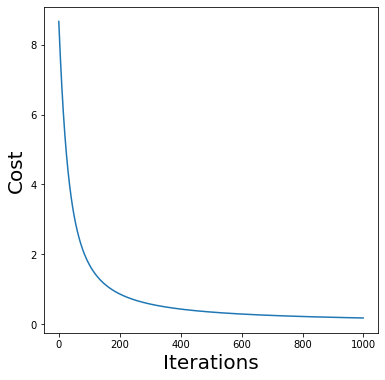

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/Copy of data55.xlsx',header=None)

train, train_label, val, val_label, test, test_label = holdout_crossvalid(df, 0.7, 0.1, 0.2,True)

def non_linear_perceptron(train, train_label, val=None,val_label=None,test=None,test_label=None,alpha=0.001,iters=1000):

    np.random.seed(42)
    w = np.random.rand(1, train.shape[1])*0.01
    b = 0
    alpha = alpha
    cost = []
    for i in range(iters):
        a = np.dot(train, w.T) + b
        h = sigmoid(a)
        cnt = 0
        J = 0.5 * np.sum((h - train_label)**2, axis=0)
        w = w - alpha * np.sum(np.dot(((h - train_label) * h * (1 - h)).T, train),axis=0)
        b = b - alpha * np.sum(((h - train_label) * h * (1 - h)), axis=0)
        cost.append(J)
        if i%1==0 and i<=12:
            _,_,accuracy=acc(np.round(h),train_label)
            print("Training split accuracy for iteration",i,":",accuracy*100,"%")

            if val is not None:
                _,_,accuracy=acc(np.round(sigmoid(np.dot(val, w.T) + b)),val_label)
                print("Validation split accuracy :",accuracy*100,"%")
            print("\n")
    if test is not None:
        SE,SP,accuracy=acc(np.round(sigmoid(np.dot(test, w.T) + b)),test_label)
        print("Test split Sensitivity and Specificity : ",SE,SP)
        print("Test split Accuracy :",accuracy*100,"%")


    return cost

cost = non_linear_perceptron(train, train_label, val, val_label, test,test_label)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_xlabel('Iterations', fontsize=20)
ax.set_ylabel('Cost', fontsize=20)
plt.plot(cost)

## Q.2 Kernel Perceptron

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/Copy of data55.xlsx',header=None)

train, train_label, val, val_label, test, test_label = holdout_crossvalid(df, 0.7, 0.1, 0.2,True)

#Kernel Functions
def kernel(u, v, key="poly", n=5, sig=5):
    if key == "poly":
        return np.power((np.dot(u, v) + 1),n)
    if key == "rbf":
        return np.exp(-(0.5 / sig) * (np.linalg.norm((v - u)))**2)

def kernel_perceptron(train, train_label, test, test_label,iters=500):
    alpha = np.zeros((1, train.shape[0]))
    for k in range(iters):
        yhat = 0
        for j in range(train.shape[0]):
            yhat = 0
            for i in range(train.shape[0]):
                yhat += (alpha[0, i] * train_label[i] *
                         kernel(train[i], train[j], "poly"))
            yhat = np.sign(yhat)
            if yhat==-1:
                yhat=0
            if yhat != train_label[j]:
                alpha[0, j] += 1
    ls = []
    for j in range(train.shape[0]):
        yhat = 0
        for i in range(train.shape[0]):
            yhat += (alpha[0, i] * train_label[i] *
                     kernel(train[i], train[j], "poly"))
        yhat = np.sign(yhat)
        if yhat==-1:
            yhat=0
        ls.append(yhat)        
    
    SE,SP,accuracy=acc(ls,train_label)
    print("Training split Sensitivity and Specificity :",SE,SP)
    print("Training split Accuracy :",accuracy*100,"%","\n")
    ls = []
    for j in range(val.shape[0]):
        yhat = 0
        for i in range(train.shape[0]):
            yhat += (alpha[0, i] * train_label[i] *
                     kernel(train[i], val[j], "poly"))
        yhat = np.sign(yhat)
        if yhat==-1:
            yhat=0
        ls.append(yhat)        
    
    SE,SP,accuracy=acc(ls,val_label)
    print("Validation split Sensitivity and Specificity :",SE,SP)
    print("Validation split Accuracy :",accuracy*100,"%","\n")

    ls = []
    for j in range(test.shape[0]):
        yhat = 0
        for i in range(train.shape[0]):
            yhat += (alpha[0, i] * train_label[i] *
                     kernel(train[i], test[j], "poly"))
        yhat = np.sign(yhat)
        if yhat==-1:
            yhat=0
        ls.append(yhat)
    SE,SP,accuracy=acc(ls,test_label)

    print("Test split Sensitivity and Specificity :",SE,SP)
    print("Test split Accuracy :",accuracy*100,"%")

    return (alpha)

alpha=kernel_perceptron(train,train_label,test,test_label)

Training split Sensitivity and Specificity : 1.0 1.0
Training split Accuracy : 100.0 % 

Validation split Sensitivity and Specificity : 1.0 1.0
Validation split Accuracy : 100.0 % 

Test split Sensitivity and Specificity : 1.0 1.0
Test split Accuracy : 100.0 %


## Q.3 MLP


In [ ]:
mat = scipy.io.loadmat('/content/drive/MyDrive/Copy of data5.mat')

data = np.array(mat['x'])
vec=data
x=[]
for i in range(vec.shape[1]-1):
    x.append((vec[:,i]-np.mean(vec[:,i]))/np.std(vec[:,i]))
x.append(vec[:,72])
norm_data=np.array(x).T
norm_data = np.insert(norm_data,72, 1,axis=1)

#Pre-processing for 5-Fold cross validation
k=5  # No. of folds
sub_len=int(norm_data.shape[0]/5)
sub_data=[]
start=0
for i in range(k):
    sub_data.append(norm_data[start:start+sub_len,:74])
    start+=sub_len
sub_data=np.array(sub_data)




train, train_label, val, val_label, test, test_label = holdout_crossvalid(data, 0.7, 0.1, 0.2,True)

np.unique(train_label)  #No. of classes

array([0., 1.])

In [ ]:
#MLP architecture

In [ ]:
def MLP(train_X, train_Y, test_X, test_Y,val_X=None, val_Y=None,g=None, num_iterations=1000):
    alpha = [0.00001, 0.00001, 0.00001]
    train_X = train_X.T
    test_X=test_X.T
    train_Y = train_Y
    
    train_size = train_X.shape[1]

    num_hidden1 = 70
    num_hidden2 = 80

    W1 = np.random.randn(num_hidden1, train_X.shape[0])
    b1 = np.zeros((num_hidden1, 1))

    W2 = np.random.randn(num_hidden2, num_hidden1)
    b2 = np.zeros((num_hidden2, 1))

    W3 = np.random.randn(1, num_hidden2)
    b3 = np.zeros((1, 1))

    loss = []
    for iteration in range(num_iterations):

        Z1 = np.dot(W1, train_X) + b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(W2, A1) + b2
        A2 = sigmoid(Z2)
        Z3 = np.dot(W3, A2) + b3
        Y_tilda = sigmoid(Z3).reshape(-1, 1)
        if iteration % 100 == 0:
            error = (np.sum(np.power(
                (Y_tilda - train_Y), 2))) / (train_size * 6)  
            loss.append(error)

        delta_3 = (Y_tilda - train_Y).T
        delta_2 = W3.T.dot((delta_3)) * sigmoid(A2, deriv=True)
        delta_1 = W2.T.dot((delta_2)) * sigmoid(A1, deriv=True)

        W3 = W3 - alpha[0] * np.dot(delta_3, A2.T) / 3 * train_size
        b3 = b3 - alpha[0] * np.sum(delta_3, axis=1,
                                    keepdims=True) / 3 * train_size
        W2 = W2 - alpha[1] * np.dot(delta_2, A1.T) / 3 * train_size
        b2 = b2 - alpha[1] * np.sum(delta_2, axis=1,
                                    keepdims=True) / 3 * train_size
        W1 = W1 - alpha[2] * np.dot(delta_1, train_X.T) / 3 * train_size
        b1 = b1 - alpha[2] * np.sum(delta_1, axis=1,
                                    keepdims=True) / 3 * train_size
                                    
    if g is not None:
      fig = plt.figure(figsize=(6, 6))
      ax = fig.add_subplot(111)
      ax.set_xlabel('Iterations', fontsize=20)
      ax.set_ylabel('Cost', fontsize=20)
      plt.plot(loss)
    count = 0
    temp = np.round(Y_tilda)
    for i in range(train_X.shape[1]):

        if train_Y[i] == temp[i]:
            count += 1
    accuracy_train = count * 100 / train_X.shape[1]

    Z1 = np.dot(W1, test_X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    Z3 = np.dot(W3, A2) + b3

    Y_tilda = sigmoid(Z3).reshape(-1, 1)

    count = 0
    temp = np.round(Y_tilda)
    for i in range(test_X.shape[1]):

        if test_Y[i] == temp[i]:
            count += 1
    accuracy_test = count * 100 / test_X.shape[1]
    if val_X is not None:
      val_X=val_X.T
      Z1 = np.dot(W1, val_X) + b1
      A1 = sigmoid(Z1)
      Z2 = np.dot(W2, A1) + b2
      A2 = sigmoid(Z2)
      Z3 = np.dot(W3, A2) + b3

      Y_tilda = sigmoid(Z3).reshape(-1, 1)

      count = 0
      temp = np.round(Y_tilda)
      for i in range(val_X.shape[1]):

          if val_Y[i] == temp[i]:
              count += 1
      accuracy_val = count * 100 / val_X.shape[1]
      return accuracy_train, accuracy_test,accuracy_val


    return accuracy_train, accuracy_test

In [ ]:
#Hold-out cross-validation

Training Accuracy 100.0 
 Test Accuracy 93.27146171693735 
 Validation Accuracy 91.58878504672897


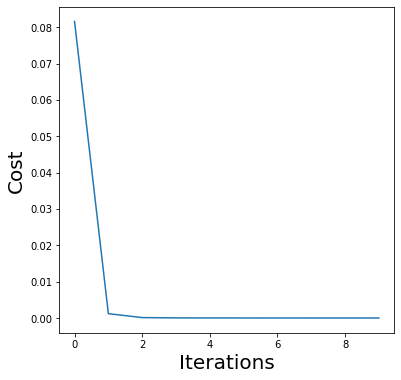

In [ ]:
a,b,c=MLP(train, train_label, test, test_label,val, val_label,num_iterations=1000,g=1)
print("Training Accuracy",a,'\n',"Test Accuracy",b,'\n',"Validation Accuracy",c)

In [ ]:
#5 Fold Cross Validation

accu=0
cnt = 1
for i in range(k):
    
    test_X = sub_data[i, :, :73].reshape(-1, 73)
    test_Y = sub_data[i, :, 73].reshape(-1, 1)
    temp = np.delete(sub_data, i, axis=0)
    train_X= temp[:, :, :73].reshape(-1, 73)
    train_Y = temp[:, :,73].reshape(-1, 1)
    _,Acc=MLP(train_X, train_Y, test_X, test_Y,num_iterations=1000)
    print("Fold", cnt, "\n")
    print('Accuracy: {:f}'.format(Acc))
    print("\n")
    accu+=Acc
    cnt += 1
print("Overall Accuracy :",accu/5)

Fold 1 

Accuracy: 93.473193


Fold 2 

Accuracy: 88.811189


Fold 3 

Accuracy: 93.240093


Fold 4 

Accuracy: 87.412587


Fold 5 

Accuracy: 92.307692


Overall Accuracy : 91.04895104895105


## Q.4 RBFNN

In [ ]:
mat = scipy.io.loadmat('/content/drive/MyDrive/Copy of data5.mat')

data = np.array(mat['x'])

#Data prep for kfold

vec=data
x=[]
for i in range(vec.shape[1]-1):
    x.append((vec[:,i]-np.mean(vec[:,i]))/np.std(vec[:,i]))
x.append(vec[:,72])
norm_data=np.array(x).T
norm_data = np.insert(norm_data,72, 1,axis=1)

k=5  # No. of folds
sub_len=int(norm_data.shape[0]/5)
sub_data=[]
start=0
for i in range(k):
    sub_data.append(norm_data[start:start+sub_len,:74])
    start+=sub_len
sub_data=np.array(sub_data)


def RBFNN(train,train_label,test,test_label,cm=False):
  X_train=train
  X_test=test
  Y_train=train_label
  Y_test=test_label

#Kernels
  def gaussian(x,sigma):
    r=np.linalg.norm(x)
    return math.exp(-math.pow(r,2)/math.pow(2*sigma,2))

  def multiquadratic(x,mu,b):
    return (np.linalg.norm(x-mu)**2+b**2)**0.5
 

  def kMeans(X, K=100, maxIters = 100, plot_progress = None):
      np.random.seed(42)
      centroids = X[np.random.choice(np.arange(len(X)), K)]
      for i in range(maxIters):

          C = np.array([np.argmin([np.dot(x_i-y_k, x_i-y_k) for y_k in centroids]) for x_i in X])
          if (len(np.unique(C)) < K):
              centroids = X[np.random.choice(np.arange(len(X)), K)]
          else:
              centroids = [X[C == k].mean(axis = 0) for k in range(K)]
          if plot_progress != None: plot_progress(X, C, np.array(centroids))
      return np.array(centroids) , K

  mu1,K_cent= kMeans(X_train)

  
  max1=0 
  for i in range(K_cent):
      for j in range(K_cent):
          d= np.linalg.norm(mu1[i]-mu1[j])
          if(d> max1):
              max1= d
  d= max1

  sigma= d/math.sqrt(2*K_cent)

  shape= X_train.shape
  row= shape[0]
  column= K_cent
  G= np.empty((row,column), dtype= float)
  for i in range(row):
      for j in range(column):
          G[i][j]= gaussian(X_train[i]-mu1[j],sigma)

  GTG= np.dot(G.T,G)
  GTG_inv= np.linalg.inv(GTG)
  fac= np.dot(GTG_inv,G.T)
  W= np.dot(fac,Y_train)

  row= X_test.shape[0]
  column= K_cent
  G_test= np.empty((row,column), dtype= float)
  for i in range(row):
      for j in range(column):
          G_test[i][j]= gaussian(X_test[i]-mu1[j],sigma)

  prediction= np.dot(G_test,W)
  prediction= 0.5*(np.sign(prediction-0.5)+1)
  cnt=0
  for i in range(Y_test.shape[0]):
    if prediction[i]==Y_test[i]:
      cnt+=1
  score=cnt/Y_test.shape[0]
  
  #Confusion Matrix using pandas
  if cm==True:
    data = {'y_Actual':    Y_test.ravel().tolist(),
            'y_Predicted': prediction.ravel().tolist()
            }

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    #print (confusion_matrix,'\n')
    sns.heatmap(confusion_matrix, annot=True,fmt='g')
    plt.show()

  return score*100

In [ ]:
#Holdout cross-validation

Accuracy of training set: 88.689288 

Accuracy of validation set: 87.850467 

Confusion Matrix for Test set 



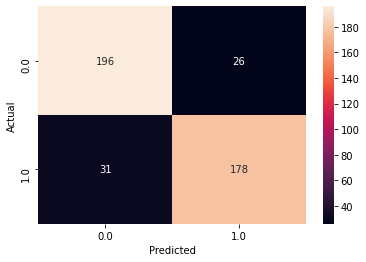



Accuracy of test set: 86.774942


In [ ]:
train, train_label, val, val_label, test, test_label = holdout_crossvalid(data, 0.7, 0.1, 0.2, True)

Acc=RBFNN(train, train_label, train, train_label)
print('Accuracy of training set: {:f}'.format(Acc),'\n')

Acc=RBFNN(train, train_label, val, val_label)
print('Accuracy of validation set: {:f}'.format(Acc),'\n')

print('Confusion Matrix for Test set','\n')
Acc=RBFNN(train, train_label, test, test_label,cm=True)
print('\n')
print('Accuracy of test set: {:f}'.format(Acc))



In [ ]:
#5 Fold Cross Validation
accu=0
cnt = 1
for i in range(k):
    test_X = sub_data[i, :, :73].reshape(-1, 73)
    test_Y = sub_data[i, :, 73].reshape(-1, 1)
    temp = np.delete(sub_data, i, axis=0)
    train_X= temp[:, :, :73].reshape(-1, 73)
    train_Y = temp[:, :,73].reshape(-1, 1)
    Acc=RBFNN(train_X, train_Y, test_X, test_Y)
    print("Fold", cnt, "\n")
    print('Accuracy: {:f}'.format(Acc))
    print("\n")
    cnt += 1
    accu+=Acc
print("Overall Accuracy :",accu/5)

Fold 1 

Accuracy: 85.314685


Fold 2 

Accuracy: 84.149184


Fold 3 

Accuracy: 90.675991


Fold 4 

Accuracy: 82.983683


Fold 5 

Accuracy: 87.645688


Overall Accuracy : 86.15384615384616


## Q.5 Stacked Autoencoder

Accuracy in train set : 100.0 % 

Accuracy in test set : 100.0 % 

Accuracy in validation set : 100.0 % 



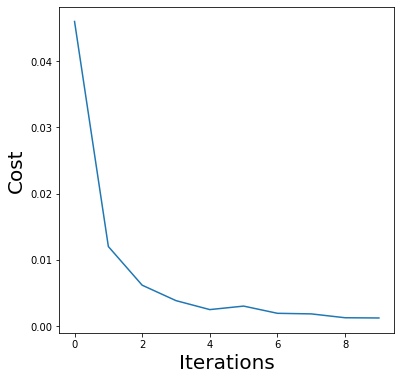

In [ ]:
import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/Copy of data5.mat')

data = np.array(mat['x'])

train, train_label, val, val_label, test, test_label = holdout_crossvalid(data, 0.7, 0.1, 0.2,True)

np.unique(train_label)  #No. of classes

def autoencoder(train,num_hidden1):
    alpha = [0.00001,0.000001,0.00001]
    num_iterations = 500

    train_X=train.T
    X=train
    train_Y=train

    num_hidden1 = num_hidden1
    train_size=200
    losses_data = {}


    W1 = np.random.randn(num_hidden1,X.shape[1])
    b1 = np.zeros((num_hidden1,1))
    W2 = np.random.randn(X.shape[1],num_hidden1)
    b2 = np.zeros((1,1))
    loss = []
    at_iteration = [] 
    for iteration in range(num_iterations):

            Z1 = np.dot(W1,train_X) + b1
            A1 = sigmoid(Z1)
            Z2 = np.dot(W2,A1) + b2
            Y_tilda = sigmoid(Z2).T
            if iteration % 100 == 0:
                    error = (np.sum(np.power((Y_tilda-train_Y),2)))/(train_size*6) # m*c*2
                    loss.append(error)
                    at_iteration.append(iteration)

            delta_2 = (Y_tilda - train_Y).T
            delta_1 = W2.T.dot((delta_2))*sigmoid(A1,deriv=True)

            W2 = W2 - alpha[1]*np.dot(delta_2,A1.T)/3*train_size
            b2 = b2 - alpha[1]*np.sum(delta_2,axis=1,keepdims=True)/3*train_size
            W1 = W1 - alpha[2]*np.dot(delta_1,train_X.T)/3*train_size
            b1 = b1 - alpha[2]*np.sum(delta_1,axis=1,keepdims=True)/3*train_size
    iterations = np.arange(len(loss))
    losses_data[(num_hidden1)] = loss 
    #plt.plot(iterations,loss)
    #plt.show()
    
    return W1

w1=autoencoder(train,64)
z1=sigmoid(np.dot(train,w1.T))
w2=autoencoder(z1,32)
z2=sigmoid(np.dot(z1,w2.T))
w3=autoencoder(z2,16)

W1=w1
W2=w2
W3=w3

alpha = [0.00001,0.000002,0.00002]
num_iterations = 1000

train_X=train.T
X=train
train_Y=train_label

accuracy_data = []
train_size=train.shape[0]
losses_data = {}
b1 = 0
b2 = 0
b3 = 0
W4 = np.random.randn(1,W3.shape[0])
b4 = np.zeros((1,1))

loss = []
at_iteration = [] 
for iteration in range(num_iterations):

        Z1 = np.dot(W1,train_X) + b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(W2,A1) + b2
        A2 = sigmoid(Z2)
        Z3 = np.dot(W3,A2) + b3
        A3=sigmoid(Z3)
        Z4= np.dot(W4,A3) + b4
        Y_tilda = sigmoid(Z4).reshape(-1,1)
        if iteration % 100 == 0:
                error = (np.sum(np.power((Y_tilda-train_Y),2)))/(train_size*6) 
                loss.append(error)
                at_iteration.append(iteration)

        delta_4 = (Y_tilda - train_Y).T

        delta_3 = W4.T.dot((delta_4))*sigmoid(A3,deriv=True)
        delta_2 = W3.T.dot((delta_3))*sigmoid(A2,deriv=True)
        delta_1 = W2.T.dot((delta_2))*sigmoid(A1,deriv=True)

        W4 = W4 - alpha[0]*np.dot(delta_4,A3.T)/3*train_size
        b4 = b4 - alpha[0]*np.sum(delta_4,axis=1,keepdims=True)/3*train_size
        W3 = W3 - alpha[0]*np.dot(delta_3,A2.T)/3*train_size
        b3 = b3 - alpha[0]*np.sum(delta_3,axis=1,keepdims=True)/3*train_size
        W2 = W2 - alpha[1]*np.dot(delta_2,A1.T)/3*train_size
        b2 = b2 - alpha[1]*np.sum(delta_2,axis=1,keepdims=True)/3*train_size
        W1 = W1 - alpha[2]*np.dot(delta_1,train_X.T)/3*train_size
        b1 = b1 - alpha[2]*np.sum(delta_1,axis=1,keepdims=True)/3*train_size

Z1 = np.dot(W1,train_X) + b1
A1 = sigmoid(Z1)
Z2 = np.dot(W2,A1) + b2
A2 = sigmoid(Z2)
Z3 = np.dot(W3,A2) + b3
A3=sigmoid(Z3)
Z4= np.dot(W4,A3) + b4
Y_tilda = sigmoid(Z4).reshape(-1,1)


count = 0
temp = Y_tilda

for i in range(train.shape[0]):
        if np.argmax(train_label[i]) == np.argmax(temp[i]):
                count += 1

accuracy = count*100/train.shape[0]
print("Accuracy in train set :",accuracy,"%","\n")

Z1 = np.dot(W1,test.T) + b1
A1 = sigmoid(Z1)
Z2 = np.dot(W2,A1) + b2
A2 = sigmoid(Z2)
Z3 = np.dot(W3,A2) + b3
A3=sigmoid(Z3)
Z4= np.dot(W4,A3) + b4
Y_tilda = sigmoid(Z4).reshape(-1,1)


count = 0

temp = Y_tilda
for i in range(test.shape[0]):
        if np.argmax(test_label[i]) == np.argmax(temp[i]):
                count += 1
accuracy = count*100/test.shape[0]
print("Accuracy in test set :",accuracy,"%","\n")


Z1 = np.dot(W1,val.T) + b1
A1 = sigmoid(Z1)
Z2 = np.dot(W2,A1) + b2
A2 = sigmoid(Z2)
Z3 = np.dot(W3,A2) + b3
A3=sigmoid(Z3)
Z4= np.dot(W4,A3) + b4
Y_tilda = sigmoid(Z4).reshape(-1,1)


count = 0

temp = Y_tilda
for i in range(val.shape[0]):
        if np.argmax(val_label[i]) == np.argmax(temp[i]):
                count += 1
accuracy = count*100/val.shape[0]
print("Accuracy in validation set :",accuracy,"%","\n")

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_xlabel('Iterations', fontsize=20)
ax.set_ylabel('Cost', fontsize=20)
plt.plot(loss)

## Q.6 ELM Classifier

In [ ]:
import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/Copy of data5.mat')

vec = np.array(mat['x'])



x=[]
for i in range(vec.shape[1]-1):
    x.append((vec[:,i]-np.mean(vec[:,i]))/np.std(vec[:,i]))
x.append(vec[:,72])
norm_data=np.array(x).T
norm_data = np.insert(norm_data,72, 1,axis=1)

k=5  # No. of folds
sub_len=int(norm_data.shape[0]/5)
sub_data=[]
start=0
for i in range(k):
    sub_data.append(norm_data[start:start+sub_len,:74])
    start+=sub_len
sub_data=np.array(sub_data)
cnt = 1



INPUT_LENGHT = train.shape[1]  +1
HIDDEN_UNITS = 1000

Win = np.random.normal(size=[INPUT_LENGHT, HIDDEN_UNITS])
print('Input Weight shape: {shape}'.format(shape=Win.shape))


def gaussian(x):
    return np.exp(-(x))
def input_to_hidden(x,o="g"):
    a = np.dot(x, Win)
    if o=="g":
        a=gaussian(a)
    else:
        a = np.tanh(a) 
    return a

def predict(x):
    x = input_to_hidden(x)
    y = np.dot(x, Wout)
    return y

def acc(h,test_output):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(test_output.shape[0]):
        if (h[i] == test_output[i]) & (test_output[i] == 0):
            TN += 1
        elif (h[i] == test_output[i]) & (test_output[i] == 1):
            TP += 1
        elif (h[i] == 0) & (test_output[i] == 1):
            FN += 1
        elif (h[i] == 1) & (test_output[i] == 0):
            FP += 1

    SE=TP/(TP+FN)
    SP=TN/(TN+FP)
    Acc=(TP+TN)/(TP+FN+TN+FP)
    return TP,FN,SE*100

acc=0
for i in range(k):
    start = 0
    test_data = sub_data[i, :, :73].reshape(-1, 73)
    test_label = sub_data[i, :, 73].reshape(-1, 1)
    temp = np.delete(sub_data, i, axis=0)
    train_data = temp[:, :, :73].reshape(-1, 73)
    train_label = temp[:, :,73].reshape(-1, 1)

    X = input_to_hidden(train_data)
    Xt = np.transpose(X)
    Wout = np.dot(np.linalg.inv(np.dot(Xt, X)), np.dot(Xt, train_label))
    y = predict(test_data)
    correct = 0
    total = y.shape[0]
    for i in range(total):
        predicted = np.argmax(y[i])
        test = np.argmax(test_label[i])
        correct = correct + (1 if predicted == test else 0)
    print("Fold", cnt, "\n")
    print('Accuracy: {:f}'.format(correct*100/total))
    print("\n")
    acc+=correct*100/total
    cnt += 1
print("Overall Accuracy :",acc/5)

Input Weight shape: (73, 1000)
Fold 1 

Accuracy: 100.000000


Fold 2 

Accuracy: 100.000000


Fold 3 

Accuracy: 100.000000


Fold 4 

Accuracy: 100.000000


Fold 5 

Accuracy: 100.000000


Overall Accuracy : 100.0


## Q.7 ELM-Autoencoders

In [ ]:
import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/Copy of data5.mat')

data = np.array(mat['x'])

train, train_label, val, val_label, test, test_label = holdout_crossvalid(data, 0.7, 0.1, 0.2,True)

np.unique(train_label)  #No. of classes

INPUT_LENGHT = train.shape[1] 
HIDDEN_UNITS = 1000

Win = np.random.rand(INPUT_LENGHT, HIDDEN_UNITS)

from numpy import linalg
def gaussian(x):
    return np.exp(-numpy.linalg.norm(x,order=2))

def input_to_hidden(x,Win,o="n"):
    a = np.dot(x, Win)
    if o=="g":
        a=gaussian(a)
    else:
        a = np.tanh(a) 
    return a

def predict(x,Wout):
    x = input_to_hidden(x,Win)
    y = np.dot(x, w)
    return y

X = input_to_hidden(train,Win)
Xt = np.transpose(X)
Wout = np.dot(np.linalg.inv(np.dot(Xt, X)), np.dot(Xt, train))

Win = np.random.rand(INPUT_LENGHT, HIDDEN_UNITS)
h1= input_to_hidden(train,Wout.T)
X = input_to_hidden(h1,Win.T)
Xt=np.transpose(X)
Wout_ = np.dot(np.linalg.inv(np.dot(Xt, X)), np.dot(Xt, h1))



h2= input_to_hidden(h1,Wout_.T)
X = input_to_hidden(h2,Win)
Xt=np.transpose(X)
Wout1 = np.dot(np.linalg.inv(np.dot(Xt, X)), np.dot(Xt, h2))

X = input_to_hidden(h2,Wout_)
Xt = np.transpose(X)
Wout2 = np.dot(np.linalg.inv(np.dot(Xt, X)), np.dot(Xt, train_label))

x=input_to_hidden(train,Wout.T)
x_=input_to_hidden(x,Wout_.T)
y_=input_to_hidden(x_,Wout1.T)
y=input_to_hidden(y_,Wout2)

correct = 0
total = y.shape[0]
for i in range(total):
    predicted = np.argmax(y[i])
    test_ = np.argmax(train_label[i])
    correct = correct + (1 if predicted == test_ else 0)
    
print('Accuracy Train set: {:f}'.format(correct*100/total),"%")

x=input_to_hidden(test,Wout.T)
x_=input_to_hidden(x,Wout_.T)
y_=input_to_hidden(x_,Wout1.T)
y=input_to_hidden(y_,Wout2)

correct = 0
total = y.shape[0]
for i in range(total):
    predicted = np.argmax(y[i])
    test_ = np.argmax(test_label[i])
    correct = correct + (1 if predicted == test_ else 0)
    
print('Accuracy Test set: {:f}'.format(correct*100/total),"%")

x=input_to_hidden(val,Wout.T)
x_=input_to_hidden(x,Wout_.T)
y_=input_to_hidden(x_,Wout1.T)
y=input_to_hidden(y_,Wout2)

correct = 0
total = y.shape[0]
for i in range(total):
    predicted = np.argmax(y[i])
    test_ = np.argmax(val_label[i])
    correct = correct + (1 if predicted == test_ else 0)
    
print('Accuracy Validation set: {:f}'.format(correct*100/total),"%")

Accuracy Train set: 100.000000 %
Accuracy Test set: 100.000000 %
Accuracy Validation set: 100.000000 %


## Q.8 SVM

In [ ]:
import scipy.io
import random as rand
import math
mat = scipy.io.loadmat('/content/drive/MyDrive/Copy of data5.mat')

data = np.array(mat['x'])

train, train_label, val, val_label, test, test_label = holdout_crossvalid(data, 0.7, 0.1, 0.2,True)

np.unique(train_label)  #No. of classes

def GaussianMatrix(X,sigma):
    row,col=X.shape
    GassMatrix=np.zeros(shape=(row,row))
    X=np.asarray(X)
    i=0
    for v_i in X:
        j=0
        for v_j in X:
            GassMatrix[i,j]=Gaussian(v_i.T,v_j.T,sigma)
            j+=1
        i+=1
    return GassMatrix

def Gaussian(x,z,sigma):
    return np.exp((-(np.linalg.norm(x-z)**2))/(2*sigma**2))



z=np.zeros((train_label.shape[0],1))
for i in range(train_label.shape[0]):
    if train_label[i]==0:
        z[i]=-1
    else:
        z[i]=1
X=train
Y=z
def SVM(X,Y,test,test_label,K,C,maxiter,val=None, val_label=None) :
  b=0
  itr=0
  m=train.shape[0]
  E=np.zeros((X.shape[0],1))
  mus=np.zeros((X.shape[0],1))
  bound=0.0001
  L=0
  H=0
  while (itr<maxiter):
      rand.seed(0)
      cnt=0
      for i in range(X.shape[0]):
          E[i] = b + np.sum((mus*Y)*K[:,i]) - Y[i]
          if ((Y[i] * E[i] < -bound and mus[i] < C) or (Y[i] * E[i] > bound and mus[i] > 0)):
              
              j = int(rand.uniform(0,m))
              while j == i:
                 
                  j =(int(rand.uniform(0,m)))
              
              E[j] = b + np.sum((mus*Y)*K[:,j].reshape(-1,1)) - Y[j]
              mu_i_old = mus[i]
              mu_j_old = mus[j]
              if (Y[i] == Y[j]):
                  L = max(0, mus[i] + mus[j] - C)
                  H = min(C, mus[i] + mus[j])
              else:
                  L = max(0, -mus[i] + mus[j])
                  H = min(C, C - mus[i] + mus[j])

              if (L == H):
                  continue

              eta = 2 * K[i, j] - K[i, i] - K[j, j]
              if (eta >= 0):
                  continue
              
              mus[j] = mus[j] - (Y[j] * (E[i] - E[j])) / eta
              mus[j] = min(H, mus[j])
              mus[j] = max(L, mus[j])
              if (abs(mus[j] - mu_j_old) < bound):
                  mus[j] = mu_j_old
                  continue
              mus[i] = mus[i] + (Y[i] * Y[j] * (-mus[j] + mus_j_old))
              b1 = b - E[i] - Y[i] * (mus[i] - mu_i_old) * K[i, j].H - Y[j] * (mus[j] - mus[i]) * K[i, j].H
              b2 = b - E[j] - Y[i] * (mus[i] - mu_i_old) * K[i, j].H - Y[j] * (mus[j] - mus[i]) * K[j, j].H
              if (mus[i] > 0 and mus[i] < C):
                  b = b1
              elif (mus[j] > 0 and mus[j] < C):
                  b = b2
              else:
                  b = (b1 + b2) / 2

              cnt += 1
      if(cnt==0):
          itr+=1
      else:
          itr=0
  Xsvm=[]
  Ysvm=[]
  mus_=[]
  for i in range(mus.shape[0]):
      if mus[i]>0:
          Ysvm.append(Y[ i])
          Xsvm.append(X[i,:])
          mus_.append(mus[i])
  Xsvm=np.array(Xsvm)
  Ysvm=np.array(Ysvm)
  mus_=np.array(mus_)

  w=np.dot((mus_*Ysvm).T,Xsvm).T

  p=np.dot(test,w)+b
  q=[]
  for i in range(p.shape[0]):
      if p[i]>0:
          q.append(1)
      else:
          q.append(0)

  t=0
  for i in range(test_label.shape[0]):
      if test_label[i]==q[i]:
          t+=1

  p=np.dot(X,w)+b
  q=[]
  for i in range(p.shape[0]):
      if p[i]>0:
          q.append(1)
      else:
          q.append(-1)

  l=0
  for i in range(Y.shape[0]):
      if Y[i]==q[i]:
          l+=1

  if val is not None:
    p=np.dot(val,w)+b
    q=[]
    for i in range(p.shape[0]):
        if p[i]>0:
            q.append(1)
        else:
            q.append(0)
    o=0
    for i in range(val_label.shape[0]):
        if val_label[i]==q[i]:
            o+=1       
    return t*100/test_label.shape[0],o*100/val_label.shape[0],l*100/X.shape[0]
  return t*100/test_label.shape[0],l*100/X.shape[0]

In [ ]:
class_acc1,class_acc2,class_acc3=SVM(X,Y,test,test_label,K=np.dot(X,X.T),C=5,maxiter=30,val=val,val_label=val_label)

In [ ]:
print("Training Accuracy :",class_acc3,"%")
print("Validation Accuracy :",class_acc2,"%")
print("Test Accuracy :",class_acc1,"%")

Training Accuracy : 84.4311377245509 %
Validation Accuracy : 85.04672897196262 %
Test Accuracy : 85.61484918793504 %


##### Multiclass classification using SVM and 1 vs all multiclass classification technique

In [ ]:
#Dataset used is from Assignment 1
df=pd.read_excel('/content/drive/MyDrive/data4.xlsx',header=None)
vec=df.to_numpy()

In [ ]:
np.random.seed(42) 
np.random.shuffle(vec)

total=vec.shape[0]
train_len=int(0.7*total)
train_features=vec[:train_len,:7]
test_features=vec[train_len:,:7]
train_output=vec[:train_len,7].reshape(-1,1)
test_output=vec[train_len:,7].reshape(-1,1)

x=[]
mean=[]
std=[]
for i in range(train_features.shape[1]):
    x.append((train_features[:,i]-np.mean(train_features[:,i]))/np.std(train_features[:,i]))
    mean.append(np.mean(train_features[:,i]))
    std.append(np.std(train_features[:,i]))


train_features=np.array(x)
train = np.append(train_features.T,np.ones([train_features.shape[1], 1]),axis=1)

x=[]
for i in range(test_features.shape[1]):
    x.append((test_features[:,i]-mean[i])/std[i])
    
test_features=np.array(x)
test = np.append(test_features.T,np.ones([test_features.shape[1], 1]),axis=1)

In [ ]:
#Preparing data for 1 vs all multiclass classification

train_label=np.zeros(shape=(train_output.shape[0],3))
for i in range(3):
    for j in range(train_output.shape[0]):
        if train_output[j]==i+1:
            train_label[j][i]=1
            
        else:
            train_label[j][i]=-1

test_label=np.zeros(shape=(test_output.shape[0],3))
for i in range(3):
    for j in range(test_output.shape[0]):
        if test_output[j]==i+1:
            test_label[j][i]=1
            
        else:
            test_label[j][i]=0

In [ ]:
_,class1_acc=SVM(train,train_label[:,0].reshape(-1,1),test,test_label[:,0].reshape(-1,1),K=np.dot(1+train,train.T)**3,C=0.1,maxiter=100)
_,class2_acc=SVM(train,train_label[:,1].reshape(-1,1),test,test_label[:,1].reshape(-1,1),K=np.dot(train,train.T),C=0.01,maxiter=100)
_,class3_acc=SVM(train,train_label[:,2].reshape(-1,1),test,test_label[:,2].reshape(-1,1),K=np.dot(train,train.T),C=0.1,maxiter=200)

In [ ]:
print("Accuracy Class1 Class2 Class 3 - ",round(class1_acc,4),'%',class2_acc,'%',round(class3_acc,4),'%')
print("Overall Accuracy",round((class1_acc+class2_acc+class3_acc)/3,4),'%')

Accuracy Class1 Class2 Class 3 -  100.0 % 63.80952380952381 % 88.5714 %
Overall Accuracy 84.127 %


## Q.9 1D CNN

In [ ]:
mat = scipy.io.loadmat('/content/drive/MyDrive/Copy of input.mat')
mat_ = scipy.io.loadmat('/content/drive/MyDrive/Copy of class_label.mat')
data = np.array(mat['x']).T
label=np.array(mat_['y'])

In [ ]:
temp=[]
for i in range(data.shape[0]):
    temp.append(data[i][0].T)

In [ ]:
train=np.array(temp)

In [ ]:
num_classes = 7
input_shape = train.T.shape[0:2]

In [ ]:
#Holdout cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=1)
y_train = keras.utils.to_categorical(np.asarray(y_train)-1)
y_test=keras.utils.to_categorical(np.asarray(y_test)-1)

In [ ]:
#CNN Model

In [ ]:
model = keras.Sequential(
    [
        layers.Conv1D(20, kernel_size=7, input_shape=(800,12),activation="relu"),
        layers.MaxPooling1D(pool_size=3,strides=3),
        layers.Conv1D(60, kernel_size=7,activation="relu"),
        layers.MaxPooling1D(pool_size=3,strides=3),
        layers.Dropout(.7),
        layers.Conv1D(120, kernel_size=7),
        layers.Conv1D(120, kernel_size=7),
        layers.Flatten(),
        layers.Dense(2000, activation="relu"),
        layers.Dense(700),
        layers.Dense(500),
        layers.Dense(num_classes, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 794, 20)           1700      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 264, 20)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 258, 60)           8460      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 86, 60)            0         
_________________________________________________________________
dropout (Dropout)            (None, 86, 60)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 120)           50520     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 74, 120)           1

In [ ]:
batch_size = 512
epochs = 8

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.125)

Epoch 1/8
24/24 [==============================] - 2s 74ms/step - loss: 0.9682 - accuracy: 0.6313 - val_loss: 0.0519 - val_accuracy: 0.9825
Epoch 2/8
24/24 [==============================] - 1s 49ms/step - loss: 0.0679 - accuracy: 0.9791 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 3/8
24/24 [==============================] - 1s 49ms/step - loss: 0.0235 - accuracy: 0.9943 - val_loss: 4.4610e-04 - val_accuracy: 1.0000
Epoch 4/8
24/24 [==============================] - 1s 49ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 5.9081e-05 - val_accuracy: 1.0000
Epoch 5/8
24/24 [==============================] - 1s 49ms/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 2.3375e-04 - val_accuracy: 1.0000
Epoch 6/8
24/24 [==============================] - 1s 48ms/step - loss: 0.0107 - accuracy: 0.9973 - val_loss: 3.1451e-04 - val_accuracy: 1.0000
Epoch 7/8
24/24 [==============================] - 1s 49ms/step - loss: 0.0086 - accuracy: 0.9982 - val_loss: 5.7699e-05 - val_accuracy: 1.0000


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1]*100,"%")

Test loss: 8.370493742404506e-05
Test accuracy: 100.0 %


In [ ]:
predictions = model.predict(X_test)
predictions = predictions.argmax( axis=1)
#predictions

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), predictions)
cm = cm/cm.sum(axis=1)[:, np.newaxis]
l=np.unique(predictions)

Text(69.0, 0.5, 'True')

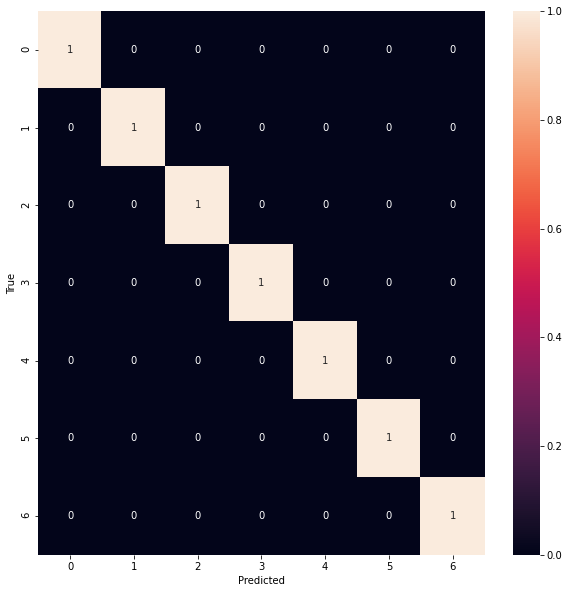

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(
    cm, annot=True,
    xticklabels=set(l),
    yticklabels=set(l))
plt.xlabel("Predicted")
plt.ylabel("True")

## Q.10 2D CNN

In [ ]:
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/Copy of class1_images.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive")
# with zipfile.ZipFile("/content/drive/MyDrive/Copy of class2_images.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive")
# with zipfile.ZipFile("/content/drive/MyDrive/Copy of class3_images.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive")

In [ ]:
#Pre-processing images

In [ ]:
image_list = []
label=[]
for filename in glob.glob('/content/drive/MyDrive/class1_images/*.png'): 
    im=Image.open(filename)
    im=im.resize((28, 28))
    data = np.asarray(im)/255
    image_list.append(data)
    label.append(1)
class1=np.array(image_list)

image_list = []
for filename in glob.glob('/content/drive/MyDrive/class2_images/*.png'): 
    im=Image.open(filename)
    im=im.resize((28, 28))
    data = np.asarray(im)/255
    image_list.append(data)
    label.append(2)
class2=np.array(image_list)

image_list = []
for filename in glob.glob('/content/drive/MyDrive/class3_images/*.png'): 
    im=Image.open(filename)
    im=im.resize((28, 28))
    data = np.asarray(im)/255
    image_list.append(data)
    label.append(3)
class3=np.array(image_list)
label=np.array(label)

In [ ]:
#CNN Model

In [ ]:
def create_model():
  model = Sequential()

  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,3)))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.5))


  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.5))


  model.add(Flatten())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation = "relu"))
  model.add(Dense(64, activation = "relu"))
  model.add(Dense(32, activation = "relu"))
  model.add(Dense(3, activation = "softmax"))
  return model

In [ ]:
#Hold-out cross-validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.vstack((class1,class2,class3)), label, test_size=0.2, random_state=1)
y_train = keras.utils.to_categorical(np.asarray(y_train)-1)
y_test=keras.utils.to_categorical(np.asarray(y_test)-1)

In [ ]:
batch_size = 64
epochs = 100
model=create_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.125)

Epoch 1/100
8/8 [==============================] - 0s 50ms/step - loss: 1.1107 - accuracy: 0.3472 - val_loss: 1.0955 - val_accuracy: 0.3750
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0993 - accuracy: 0.3393 - val_loss: 1.0975 - val_accuracy: 0.3750
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0983 - accuracy: 0.3552 - val_loss: 1.0978 - val_accuracy: 0.3750
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0971 - accuracy: 0.3690 - val_loss: 1.0972 - val_accuracy: 0.3750
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 1.0975 - accuracy: 0.3611 - val_loss: 1.0960 - val_accuracy: 0.3750
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0993 - accuracy: 0.3472 - val_loss: 1.0981 - val_accuracy: 0.3750
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0979 - accuracy: 0.3433 - val_loss: 1.0981 - val_accuracy: 0.3750
Epoch 8/100
8/8 [===

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1]*100,"%")

Test loss: 0.04308682307600975
Test accuracy: 98.61111044883728 %


In [ ]:
predictions = model.predict(X_test)
predictions = predictions.argmax( axis=1)
#predictions

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), predictions)
cm = cm/cm.sum(axis=1)[:, np.newaxis]
l=np.unique(predictions)

Text(69.0, 0.5, 'True')

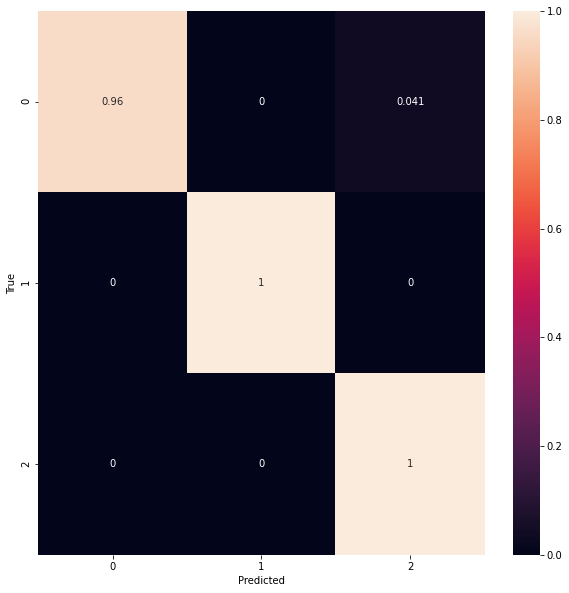

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(
    cm, annot=True,
    xticklabels=set(l),
    yticklabels=set(l))
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
#10-fold cross-validation

In [ ]:
n_split=10
a=0
X=np.vstack((class1,class2,class3))
f=0
for train_index,test_index in KFold(n_split).split(X):
  f+=1
  x_train,x_test=X[train_index],X[test_index]
  y_train,y_test=label[train_index],label[test_index]
  y_train = keras.utils.to_categorical(y_train-1,num_classes=3)
  y_test=keras.utils.to_categorical(y_test-1,num_classes=3)

  batch_size = 128
  epochs = 200
  model=create_model()
  opt = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

  history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.125,verbose=0)
  print("\n")
  print("Fold :",f,"\n")
  print("Training Accuracy",history.history['accuracy'][-1]*100,"%")
  print("Validation Accuracy",history.history['val_accuracy'][-1]*100,"%")
  print('Test Accuracy ',model.evaluate(x_test,y_test,verbose=0)[1]*100,"%")
  a+=model.evaluate(x_test,y_test,verbose=0)[1]*100
print("\n")




Fold : 1 

Training Accuracy 99.29453134536743 %
Validation Accuracy 88.88888955116272 %
Test Accuracy  100.0 %


Fold : 2 

Training Accuracy 99.29453134536743 %
Validation Accuracy 28.395062685012817 %
Test Accuracy  100.0 %


Fold : 3 

Training Accuracy 100.0 %
Validation Accuracy 53.08641791343689 %
Test Accuracy  80.55555820465088 %


Fold : 4 

Training Accuracy 99.47090148925781 %
Validation Accuracy 66.66666865348816 %
Test Accuracy  95.83333134651184 %


Fold : 5 

Training Accuracy 98.23633432388306 %
Validation Accuracy 59.25925970077515 %
Test Accuracy  97.22222089767456 %


Fold : 6 

Training Accuracy 99.47090148925781 %
Validation Accuracy 71.60493731498718 %
Test Accuracy  95.83333134651184 %


Fold : 7 

Training Accuracy 98.94179701805115 %
Validation Accuracy 81.4814805984497 %
Test Accuracy  95.83333134651184 %


Fold : 8 

Training Accuracy 98.76543283462524 %
Validation Accuracy 62.962961196899414 %
Test Accuracy  48.61111044883728 %


Fold : 9 

Training Accur

## Q.11

## Things Learnt :



1. Non-linear perceptron algorithm
2. Forward Propagation Back Propagation
3. Multi-layer neural network
4. Kernel perceptron algorithm
5. Radial basis function neural network
6. Stacked autoencoder
7. ELM
8. ELM-Autoencoder
9. Binary and multiclass SVM
10. Multi-channel 1D deep CNN architecture
11. 2D deep CNN classifier
12. Confusion Matrix